In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import speclite.filters as sp
from speclite import filters
from scipy.ndimage import sum_labels, mean
from scipy.stats import linregress, spearmanr


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

In [2]:
kin_path = Path('IC3392_KIN_maps.fits')
print(f"Loading kinematic map from {kin_path}")
with fits.open(kin_path) as hdul:
    kin_info = hdul.info()
    
    # Read data from all extensions except PRIMARY
    extension_names = [hdul[i].name for i in range(1, len(hdul))]
    print(f"Available extensions: {extension_names}")
    
    # Read each extension's data before closing the file
    for ext_name in extension_names:
        if ext_name and ext_name != "PRIMARY":
            globals()[ext_name] = hdul[ext_name].data
            print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")

print("All data loaded successfully!")


Loading kinematic map from IC3392_KIN_maps.fits
Filename: IC3392_KIN_maps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  V             1 ImageHDU        26   (437, 438)   float64   
  2  SIGMA         1 ImageHDU        26   (437, 438)   float64   
  3  H3            1 ImageHDU        26   (437, 438)   float64   
  4  H4            1 ImageHDU        26   (437, 438)   float64   
  5  FORM_ERR_V    1 ImageHDU        26   (437, 438)   float64   
  6  FORM_ERR_SIGMA    1 ImageHDU        26   (437, 438)   float64   
  7  FORM_ERR_H3    1 ImageHDU        26   (437, 438)   float64   
  8  FORM_ERR_H4    1 ImageHDU        26   (437, 438)   float64   
  9  SNR_POSTFIT    1 ImageHDU        26   (437, 438)   float64   


Available extensions: ['V', 'SIGMA', 'H3', 'H4', 'FORM_ERR_V', 'FORM_ERR_SIGMA', 'FORM_ERR_H3', 'FORM_ERR_H4', 'SNR_POSTFIT']
Loaded V: shape (438, 437)
Loaded SIGMA: shape (438, 437)
Loaded H3: shape (438, 437)
Loaded H4: shape (438, 437)
Loaded FORM_ERR_V: shape (438, 437)
Loaded FORM_ERR_SIGMA: shape (438, 437)
Loaded FORM_ERR_H3: shape (438, 437)
Loaded FORM_ERR_H4: shape (438, 437)
Loaded SNR_POSTFIT: shape (438, 437)
All data loaded successfully!


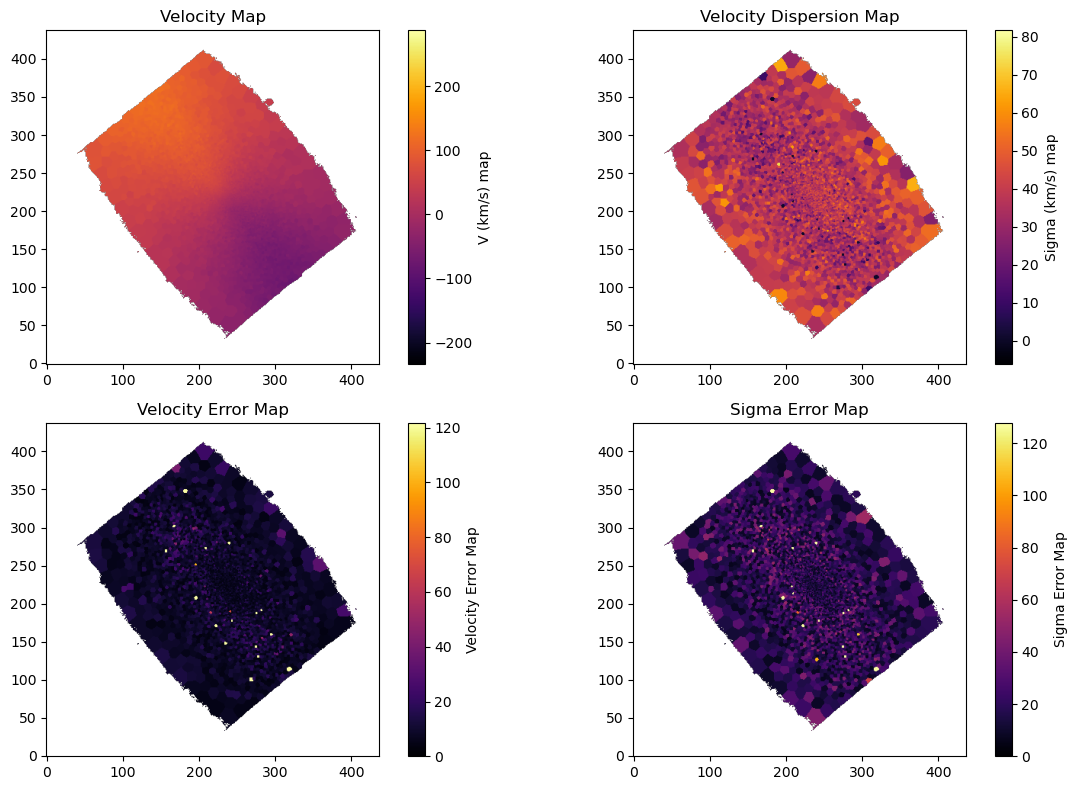

In [3]:
# Plot the V, Sigma, FORM_ERR_V and FORM_ERR_SIGMA maps
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(V, origin='lower', cmap='inferno', vmin=np.nanmedian(V)-5*np.nanstd(V), vmax=np.nanmedian(V)+5*np.nanstd(V))
plt.colorbar(label='V (km/s) map')
plt.title('Velocity Map')
plt.subplot(2, 2, 2)
plt.imshow(SIGMA, origin='lower', cmap='inferno', vmin=np.nanmedian(SIGMA)-5*np.nanstd(SIGMA), vmax=np.nanmedian(SIGMA)+5*np.nanstd(SIGMA))
plt.colorbar(label='Sigma (km/s) map')
plt.title('Velocity Dispersion Map')
plt.subplot(2, 2, 3)
plt.imshow(FORM_ERR_V, origin='lower', cmap='inferno', vmin=0, vmax=5*np.nanstd(FORM_ERR_V))
plt.colorbar(label='Velocity Error Map')
plt.title('Velocity Error Map')
plt.subplot(2, 2, 4)
plt.imshow(FORM_ERR_SIGMA, origin='lower', cmap='inferno', vmin=0, vmax=5*np.nanstd(FORM_ERR_SIGMA))
plt.colorbar(label='Sigma Error Map')
plt.title('Sigma Error Map')
plt.tight_layout()
plt.show()

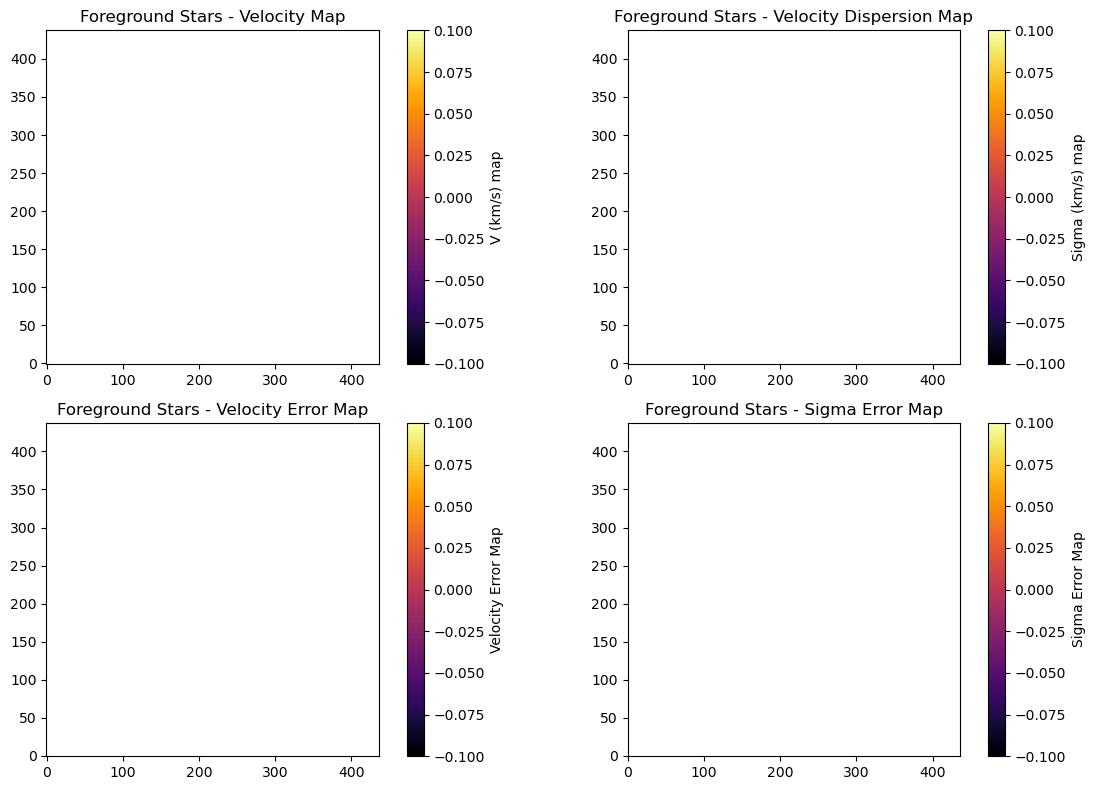

In [6]:
# Foreground star selection: outside median ± 5*std in V or Sigma, or >5*std in errors of V or Sigma, while preserving NaNs
foreground_stars = np.where(
    (np.abs(V - np.nanmedian(V)) >= 5 * np.nanstd(V)) 
    | (np.abs(SIGMA - np.nanmedian(SIGMA)) >= 5 * np.nanstd(SIGMA)) 
    # | (FORM_ERR_V >= 5 * np.nanstd(FORM_ERR_V)) 
    # | (FORM_ERR_SIGMA >= 5 * np.nanstd(FORM_ERR_SIGMA))
)

# Create a mask for foreground stars
foreground_mask = np.zeros_like(V, dtype=bool)
foreground_mask[foreground_stars] = True

# Plot the V, Sigma, FORM_ERR_V and FORM_ERR_SIGMA maps for foreground stars
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(np.where(foreground_mask, V, np.nan), origin='lower', cmap='inferno')
plt.colorbar(label='V (km/s) map')
plt.title('Foreground Stars - Velocity Map')
plt.subplot(2, 2, 2)
plt.imshow(np.where(foreground_mask, SIGMA, np.nan), origin='lower', cmap='inferno')
plt.colorbar(label='Sigma (km/s) map')
plt.title('Foreground Stars - Velocity Dispersion Map')
plt.subplot(2, 2, 3)
plt.imshow(np.where(foreground_mask, FORM_ERR_V, np.nan), origin='lower', cmap='inferno')
plt.colorbar(label='Velocity Error Map')
plt.title('Foreground Stars - Velocity Error Map')
plt.subplot(2, 2, 4)
plt.imshow(np.where(foreground_mask, FORM_ERR_SIGMA, np.nan), origin='lower', cmap='inferno')
plt.colorbar(label='Sigma Error Map')
plt.title('Foreground Stars - Sigma Error Map')
plt.tight_layout()
plt.show()